In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import utils
from vgg.imagenet_classes import class_names
from vgg.VGG import generate_VGG16

In [3]:
print("TensorFlow version : {}".format(tf.__version__))
print("Devices : {}".format(utils.get_tensorflow_devices()))

TensorFlow version : 1.1.0
Devices : [('/cpu:0', 'CPU')]


In [4]:
###############################################################################
# Constants for the image input and output.
###############################################################################


LOGS = 'logs/3.0'
# Output folder for the images.
OUTPUT_DIR = 'output/'
# Style image to use.
STYLE_IMAGE = 'images/udnie.jpg'
# Content image to use.
CONTENT_IMAGE = 'images/hongkong.jpg'
# Image dimensions constants. 

IMG_W = 256
IMG_H = 256
CHANNELS = 3

MODEL_WEIGHTS = 'vgg/vgg16.npy'

DATA_DIR = 'COCO/train2014/'

In [5]:
if tf.gfile.Exists(LOGS):
    tf.gfile.DeleteRecursively(LOGS)
tf.gfile.MakeDirs(LOGS)

In [6]:
# Constant to put more emphasis on content loss.
BETA = 1
# Constant to put more emphasis on style loss.
ALPHA = 25

In [7]:
BATCH_SIZE = 4

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [9]:
def get_norm(x):
    with tf.variable_scope("instance_norm"):
        eps = 1e-6
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        #mean = tf.reshape(mean, [-1])
        #var = tf.reshape(var, [-1])
        return (x - mean) / (tf.sqrt(var) + eps)

In [10]:
def _conv_block(prev_layer, n, S, stride, layer_name, relu=True):
    with tf.name_scope(layer_name):
        # add reflect padding
        pad = n // 2
        padded = tf.pad(prev_layer, [[0,0],[pad,pad],[pad,pad],[0,0]], "REFLECT")
        # C : number of channels in prev_layer
        C = prev_layer.get_shape().as_list()[-1]
        kernel = tf.Variable(tf.random_normal([n, n, C, S], stddev=np.sqrt(2./(n*n*C)), name="weights"))
        conv = tf.nn.conv2d(padded, kernel, [1, stride, stride, 1], padding='VALID')
        conv_biases = tf.Variable(tf.zeros([S]), name="biases")
        bias = tf.nn.bias_add(conv, conv_biases)
        if relu:
            norm = get_norm(bias)
            return tf.nn.relu(norm)
        else:
            return bias
        
def _residual_block(prev_layer, layer_name, S=3):
    with tf.name_scope(layer_name):
        _,_,_, C = prev_layer.get_shape().as_list()
        conv = _conv_block(prev_layer, S, C, 1, "{}-a".format(layer_name))
        
        return prev_layer + get_norm(_conv_block(conv, S, C, 1,"{}-b".format(layer_name), relu=False))

    
def _deconv_block(prev_layer, n, S, stride, layer_name):
    with tf.variable_scope(layer_name):
        b, h, w, C = prev_layer.get_shape().as_list()
        kernel = tf.Variable(tf.random_normal([n, n, S, C], stddev=np.sqrt(2./(n*n*C)), name="weights"))
        deconv = tf.nn.conv2d_transpose(prev_layer, kernel, [b, h * stride, w * stride, S], [1, stride, stride, 1], padding='SAME')
        biases = tf.Variable(tf.zeros([S]), name="biases")         
        bias = tf.nn.bias_add(deconv, biases)
        norm = get_norm(bias)
        return tf.nn.relu(norm)

In [11]:
generator={}
MEAN = [103.939, 116.779, 123.68]

with tf.name_scope('input_images'):
    generator['input'] = tf.placeholder(tf.float32,
                                        shape=(BATCH_SIZE, IMG_W, IMG_H, CHANNELS),
                                        name='input_images')

with tf.name_scope('preprocessing_generator'):
    red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=generator['input'])
    bgr = tf.concat(axis=3, values=[blue - MEAN[0], green - MEAN[1], red - MEAN[2], ])
    generator['preprocess'] = bgr
        
with tf.name_scope('generator'):
    generator['conv_block1'] =  _conv_block(generator['preprocess'], 9, 32, 1, 'conv_block1')
    generator['conv_block2'] =  _conv_block(generator['conv_block1'], 3, 64, 2, 'conv_block2')
    generator['conv_block3'] =  _conv_block(generator['conv_block2'], 3, 128, 2, 'conv_block3')
    generator['residual_block1'] = _residual_block(generator['conv_block3'], 'residual_block1')
    generator['residual_block2'] = _residual_block(generator['residual_block1'], 'residual_block2')
    generator['residual_block3'] = _residual_block(generator['residual_block2'], 'residual_block3')
    generator['residual_block4'] = _residual_block(generator['residual_block3'], 'residual_block4')
    generator['residual_block5'] = _residual_block(generator['residual_block4'], 'residual_block5')
    generator['deconv_block1'] = _deconv_block(generator['residual_block5'], 3, 64, 2, 'deconv_block1')
    generator['deconv_block2'] = _deconv_block(generator['deconv_block1'], 3, 32, 2, 'deconv_block2')
    generator['final_conv'] = _conv_block(generator['deconv_block2'], 9, 3, 1, 'final_conv', relu=False)
    generator['output'] = tf.multiply(tf.tanh(generator['final_conv']/255.0), 255, name="output")


In [12]:
print(generator['output'].get_shape())

(4, 256, 256, 3)


In [13]:
from vgg.VGG import generate_VGG16

In [14]:
with tf.name_scope("VGG_generator"):
    vgg, vgg_scope = generate_VGG16(weights_file=MODEL_WEIGHTS,
                                  apply_preprocess=True,
                                  remove_top=True,
                                  input_tensor=generator['output'])

In [15]:
with tf.name_scope("VGG_content"):
    content_vgg, _ = generate_VGG16(weights_file=MODEL_WEIGHTS,
                                  scope=vgg_scope,
                                  apply_preprocess=True,
                                  remove_top=True,
                                  input_tensor=generator['input'])

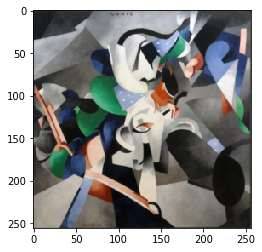

In [16]:
style_image = utils.load_image(STYLE_IMAGE, expand_dim=True, width=IMG_W, height=IMG_H)
plt.imshow(style_image[0])

### Debug Gram dimensions

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
STYLE_LAYERS = [
    ('conv1_2', 1.0),
    ('conv2_2', 1.0),
    ('conv3_3', 1.0),
    ('conv4_3', 1.0)
]


def style_loss_func(sess, model, style_image):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix_np(F, B, N, M):
        """
        The gram matrix G.
        """
        F = np.reshape(F, (B, M, N))
        return np.matmul(np.transpose(F, (0, 2, 1)), F)
    
    def _gram_matrix_tf(F, B, N, M):
        """
        The gram matrix G.
        """
        F = tf.reshape(F, (B, M, N))
        return tf.matmul(tf.transpose(F, perm=[0,2,1]), F)

    def _style_loss(a, x):
        """
        The style loss calculation.
        """
        # B is the bath_size
        B = a.shape[0]
        # N is the number of filters (at layer l).
        N = a.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = a.shape[1] * a.shape[2]
        # A is the style representation of the original image (at layer l).
        A = _gram_matrix_np(a, B, N, M)
        # G is the style representation of the generated image (at layer l).
        G = _gram_matrix_tf(x, B, N, M)
        #
        result = (1/ M**2) * tf.reduce_mean(tf.pow(G - A, 2))
        return result
    
    style_images = np.asarray([style_image[0]]*BATCH_SIZE)
    feed_dict = {model['input']: style_images}
    
    E = [_style_loss(sess.run(model[layer_name], feed_dict=feed_dict), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
        
    return loss

with tf.name_scope('style_loss'):
    style_loss = style_loss_func(sess, vgg, style_image)
    tf.summary.scalar('style_loss', style_loss)
    

In [19]:
def content_loss_func(content_model, model):
    return tf.reduce_mean(tf.square(content_model['conv2_2'] - model['conv2_2']))

with tf.name_scope('content_loss'):
    content_loss = content_loss_func(content_vgg, vgg)
    tf.summary.scalar('content_loss', content_loss)
    

In [20]:
with tf.name_scope('total_loss'):
    total_loss = BETA * content_loss + ALPHA * style_loss
    tf.summary.scalar('total_loss', total_loss)

In [21]:
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(LOGS, sess.graph)

In [22]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(0.02)
    train_step = optimizer.minimize(total_loss)

In [23]:
sess.run(tf.global_variables_initializer())

In [24]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [25]:
batch_generator = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     vertical_flip=True).flow_from_directory('COCO/',
                                                         target_size=(IMG_W, IMG_H),
                                                         batch_size=BATCH_SIZE,
                                                         class_mode=None)



Found 82783 images belonging to 3 classes.


In [26]:
batch = batch_generator.next()
print(batch.shape)
print(batch.dtype)

(4, 256, 256, 3)
float32


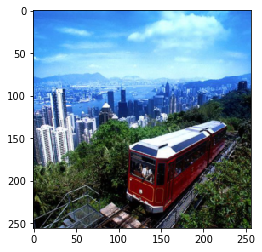

In [27]:
from scipy.misc import imread, imresize
content_image = imread(CONTENT_IMAGE)

short_edge = min(content_image.shape[:2])
yy = int((content_image.shape[0] - short_edge) / 2)
xx = int((content_image.shape[1] - short_edge) / 2)
content_image = content_image[yy: yy + short_edge, xx: xx + short_edge]

content_image = imresize(content_image, (IMG_W, IMG_H))
content_image = content_image.reshape((1, IMG_W, IMG_H, CHANNELS))

plt.imshow(content_image[0])

In [ ]:
%%time

ITERATIONS = 2000

for it in range(ITERATIONS):
    batch = batch_generator.next()
    
    feed={}
    feed[generator['input']] = batch
    
    if it == 49 : 
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        
        summary, _ = sess.run([merged, train_step],
                              feed_dict=feed,
                              options=run_options,
                              run_metadata=run_metadata)
            
        writer.add_summary(summary, it)
        writer.add_run_metadata(run_metadata, 'step%03d' % it)
            
    else :
        summary, _ = sess.run([merged, train_step], feed_dict=feed)
        writer.add_summary(summary, it)

    if it%500 == 0:
        
        _image = sess.run(generator['output'], feed_dict={generator['input']:[content_image[0]]*BATCH_SIZE})
        print('Iteration %d' % (it))
        filename = 'output/stylized_feedforward_IN_iter{}.png'.format(it)
        utils.save_image(filename, _image)
    elif it%50 == 0:
        print("--> {} / {}".format(it, ITERATIONS))

In [ ]:
writer.close()
        
image = sess.run(generator['output'], feed_dict={generator['input']:[content_image[0]]*BATCH_SIZE})
print('Iteration %d' % (it))
filename = 'output/stylized_feedforward_IN_iter{}.png'.format(it)
save_image(filename, _image)

In [ ]:
%%timeit
 _image = sess.run(generator['output'], feed_dict={input_images:[content_image[0]]*BATCH_SIZE})

In [28]:
writer.close()